<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Get-our-data" data-toc-modified-id="Get-our-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Get our data</a></span></li><li><span><a href="#Simple-Regression-Model" data-toc-modified-id="Simple-Regression-Model-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Simple Regression Model</a></span></li><li><span><a href="#The-k-$\sigma$-method" data-toc-modified-id="The-k-$\sigma$-method-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>The k-$\sigma$ method</a></span></li><li><span><a href="#Applying-Fourier-Transforms-to-the-data" data-toc-modified-id="Applying-Fourier-Transforms-to-the-data-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Applying Fourier Transforms to the data</a></span></li><li><span><a href="#Wavelet-based-modelling" data-toc-modified-id="Wavelet-based-modelling-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Wavelet based modelling</a></span></li></ul></div>

In [16]:
import pandas as pd
from matplotlib import pyplot as plt
import os
import statsmodels.api as sm
import glob
from datetime import datetime as dt
import numpy as np

# Get our data

In [17]:
start_time = dt.now()
all_csv = glob.glob(f'./data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark/**/*.csv', recursive=True)
end_time = dt.now()
print(f'Loaded the paths of {len(all_csv)} files from disk. Took {end_time-start_time}')

Loaded the paths of 100 files from disk. Took 0:00:00.004988


In [18]:
df= pd.read_csv(all_csv[0])
df

,timestamp,value,is_anomaly
0,1416726000,13.894031,0
1,1416729600,33.578274,0
2,1416733200,88.933746,0
3,1416736800,125.389424,0
4,1416740400,152.962000,0
...,...,...,...
1416,1421823600,-141.419766,0
1417,1421827200,-139.657834,0
1418,1421830800,-70.550652,0
1419,1421834400,-16.857148,0


In [19]:
df['timestamp'] = pd.to_datetime(df['timestamp'],unit='s')#format='%f' if formatting required upto nanoseconds

In [20]:
df

,timestamp,value,is_anomaly
0,2014-11-23 07:00:00,13.894031,0
1,2014-11-23 08:00:00,33.578274,0
2,2014-11-23 09:00:00,88.933746,0
3,2014-11-23 10:00:00,125.389424,0
4,2014-11-23 11:00:00,152.962000,0
...,...,...,...
1416,2015-01-21 07:00:00,-141.419766,0
1417,2015-01-21 08:00:00,-139.657834,0
1418,2015-01-21 09:00:00,-70.550652,0
1419,2015-01-21 10:00:00,-16.857148,0


# Simple Regression Model

In [21]:
X = sm.add_constant(df['value'])
model = sm.OLS(df['value'],X)
results = model.fit()

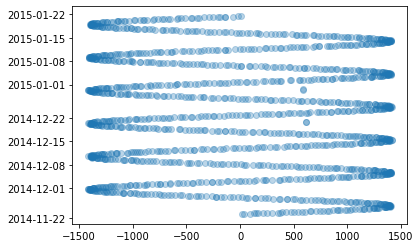

In [8]:
plt.scatter(df['value'],df['timestamp'],alpha=0.3)

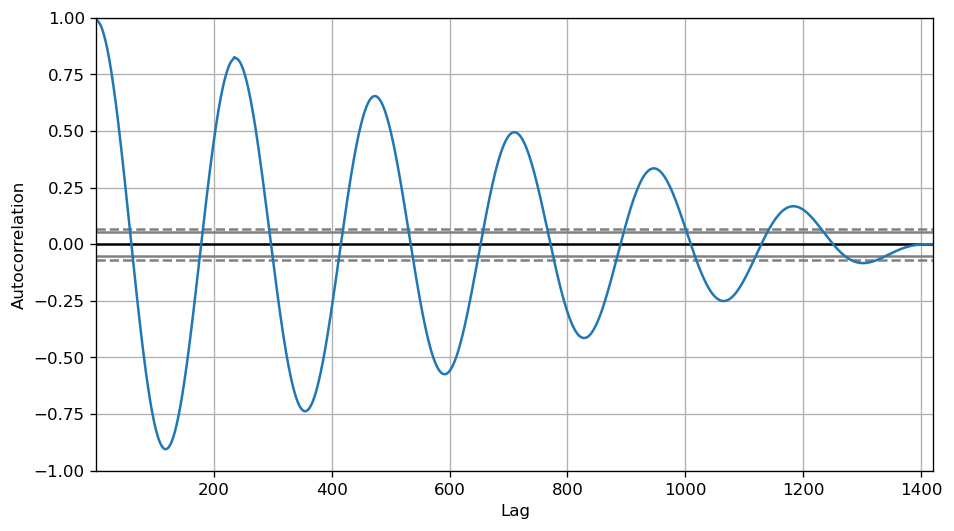

In [9]:
from pandas.plotting import autocorrelation_plot
# Draw Plot
plt.rcParams.update({'figure.figsize':(9,5), 'figure.dpi':120})
autocorrelation_plot(df.value.tolist())

C:\Users\Sanke\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


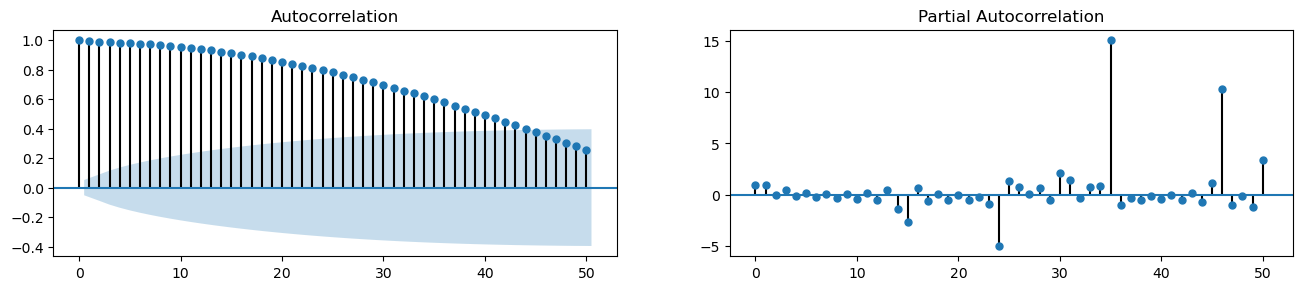

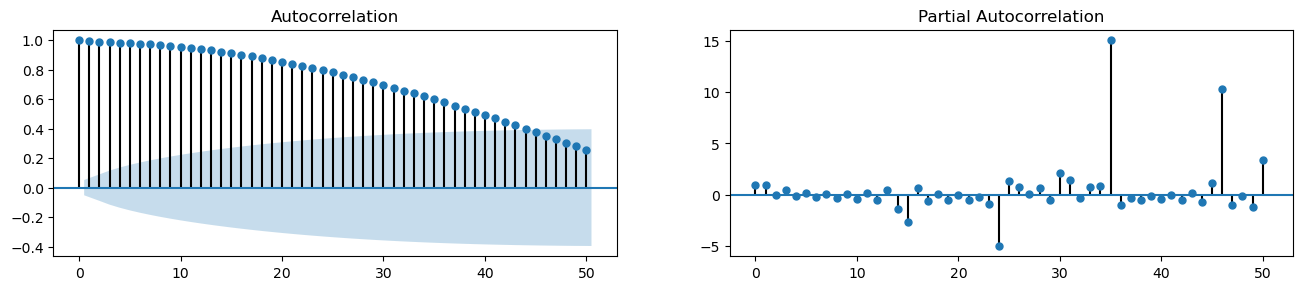

In [10]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# Calculate ACF and PACF upto 50 lags
# acf_50 = acf(df.value, nlags=50)
# pacf_50 = pacf(df.value, nlags=50)

# Draw Plot
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(df.value.tolist(), lags=50, ax=axes[0])
plot_pacf(df.value.tolist(), lags=50, ax=axes[1])

Text(0.5, 1.15, 'Lag Plots of Sun Spots Area \n(Points get wide and scattered with increasing lag -> lesser correlation)\n')

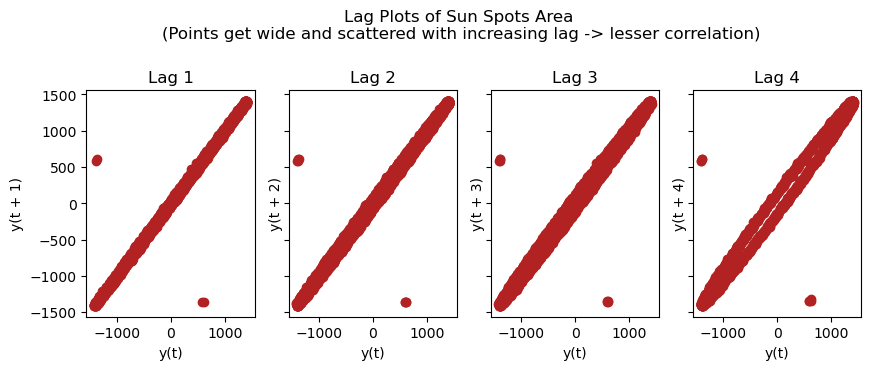

In [11]:
from pandas.plotting import lag_plot

# Plot
fig, axes = plt.subplots(1, 4, figsize=(10,3), sharex=True, sharey=True, dpi=100)
for i, ax in enumerate(axes.flatten()[:4]):
    lag_plot(df.value, lag=i+1, ax=ax, c='firebrick')
    ax.set_title('Lag ' + str(i+1))

fig.suptitle('Lag Plots of Sun Spots Area \n(Points get wide and scattered with increasing lag -> lesser correlation)\n', y=1.15)    


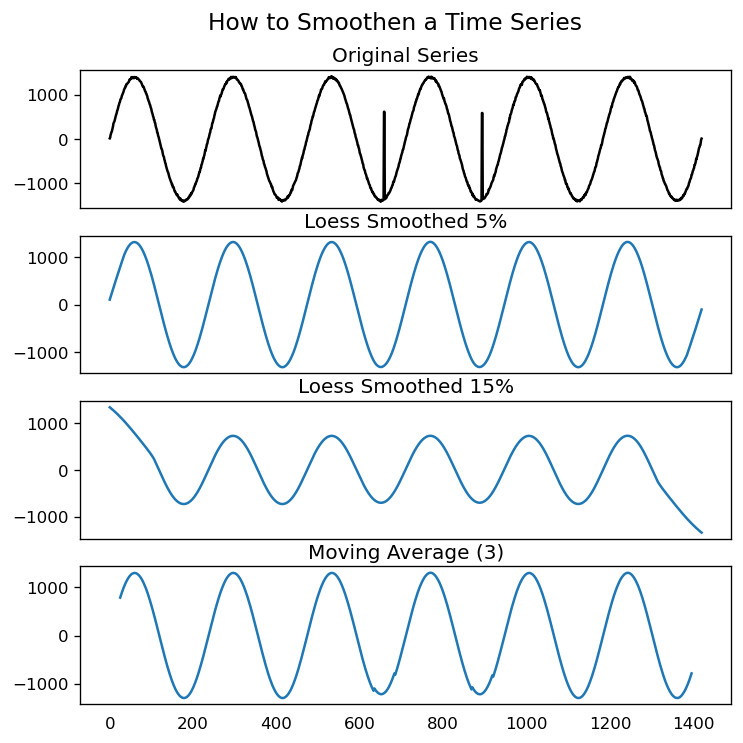

In [12]:
from statsmodels.nonparametric.smoothers_lowess import lowess

plt.rcParams.update({'xtick.bottom' : False, 'axes.titlepad':5})

# 1. Moving Average
df_ma = df.value.rolling(50, center=True).mean()

# 2. Loess Smoothing (5% and 15%)
df_loess_5 = pd.DataFrame(lowess(df.value, np.arange(len(df.value)), frac=0.05)[:, 1], index=df.index, columns=['value'])
df_loess_15 = pd.DataFrame(lowess(df.value, np.arange(len(df.value)), frac=0.15)[:, 1], index=df.index, columns=['value'])

# Plot
fig, axes = plt.subplots(4,1, figsize=(7, 7), sharex=True, dpi=120)
df['value'].plot(ax=axes[0], color='k', title='Original Series')
df_loess_5['value'].plot(ax=axes[1], title='Loess Smoothed 5%')
df_loess_15['value'].plot(ax=axes[2], title='Loess Smoothed 15%')
df_ma.plot(ax=axes[3], title='Moving Average (3)')
fig.suptitle('How to Smoothen a Time Series', y=0.95, fontsize=14)
plt.show()

# The k-$\sigma$ method

In [22]:
##FIRST DESIGN A SLIDING WINDOW ON THE DATA
def rolling_window(data,size):
    window_arr = [data[i:i+size] for i in range(len(data) - 2)]
    return window_arr

In [26]:
print(rolling_window(df['value'],5))

[0     13.894031
1     33.578274
2     88.933746
3    125.389424
4    152.962000
Name: value, dtype: float64, 1     33.578274
2     88.933746
3    125.389424
4    152.962000
5    168.365150
Name: value, dtype: float64, 2     88.933746
3    125.389424
4    152.962000
5    168.365150
6    211.863425
Name: value, dtype: float64, 3    125.389424
4    152.962000
5    168.365150
6    211.863425
7    255.452289
Name: value, dtype: float64, 4    152.962000
5    168.365150
6    211.863425
7    255.452289
8    295.065010
Name: value, dtype: float64, 5    168.365150
6    211.863425
7    255.452289
8    295.065010
9    357.805877
Name: value, dtype: float64, 6     211.863425
7     255.452289
8     295.065010
9     357.805877
10    375.746934
Name: value, dtype: float64, 7     255.452289
8     295.065010
9     357.805877
10    375.746934
11    394.292129
Name: value, dtype: float64, 8     295.065010
9     357.805877
10    375.746934
11    394.292129
12    425.906754
Name: value, dtype: float64, 9  

In [28]:
print(rolling_window(df['value'].tolist(),5)[0])

[13.894031202243099, 33.5782735451433, 88.93374617578941, 125.38942370321999, 152.961999637907]


In [29]:
def movingaverage(arr,blocksize=10):
    avg = []
    for i in rolling_window(arr,blocksize):
        avg = i.mean()
    print(avg)
    
movingaverage(df['value'])

-26.55004661987262


In [31]:
df['value'].rolling(5).mean().tolist()

[nan,
 nan,
 nan,
 nan,
 82.95149485286056,
 113.84571859647133,
 149.5027489049357,
 182.8064574667578,
 216.74157469722678,
 257.7103501484498,
 299.1867069094732,
 335.67244766852457,
 369.76334059996816,
 404.84785765741856,
 434.324117020485,
 466.8548170300397,
 503.94986950606955,
 538.9367268928785,
 574.5739211693583,
 606.1451312563324,
 639.7625279821515,
 672.7899081310363,
 707.3209327728135,
 739.9078151029018,
 773.7592494334885,
 806.0713502821311,
 837.7751920954822,
 865.5205738437201,
 889.8766273903148,
 918.428614193828,
 944.4778807355648,
 967.9032921360006,
 994.792231473007,
 1021.8067509451766,
 1048.1971047506597,
 1075.4036818126158,
 1102.1771002958237,
 1124.807771994126,
 1150.7932598888638,
 1169.606904909932,
 1191.1470029795998,
 1209.5704267903498,
 1228.0437316925618,
 1241.1523789954058,
 1255.9903600398839,
 1265.6831789824816,
 1276.0171444134537,
 1293.6584238529538,
 1310.5031050464618,
 1324.826737688358,
 1339.078820272832,
 1352.069677713806,

# Applying Fourier Transforms to the data

# Wavelet based modelling